## ML Model using CNN and LSTM
import libraries

In [1]:
#!pip install --upgrade tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

load data

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#CSV file to use for training
csv_files = ['/content/drive/MyDrive/final_training_data.csv']  # Add more file names as needed

# Load and concatenate data from multiple CSV files
data_list = []
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    data_list.append(data)

# Concatenate data from all CSV files
data = pd.concat(data_list, ignore_index=True)

In [5]:
data

,timestamp,Total,Washer,Lights,Dryer,WaterHeater,Recs,HVAC,Other
0,2023-01-18 22:00:00,164.1,0.5,25.7,0.0,0.0,12.7,33.8,91.4
1,2023-01-18 22:01:00,164.3,0.5,25.6,0.0,0.0,12.7,33.8,91.7
2,2023-01-18 22:02:00,164.1,0.6,25.8,0.0,0.0,12.5,33.9,91.3
3,2023-01-18 22:03:00,164.0,0.5,25.6,0.0,0.0,12.7,33.7,91.5
4,2023-01-18 22:04:00,164.2,0.6,25.7,0.0,0.0,12.5,33.8,91.6
...,...,...,...,...,...,...,...,...,...
5452,2023-01-22 22:07:00,1927.9,6.0,43.5,0.1,0.0,13.0,879.7,985.6
5453,2023-01-22 22:09:00,1927.3,6.0,43.3,0.1,0.0,13.0,880.9,984.0
5454,2023-01-22 22:10:00,1926.0,6.0,43.2,0.1,0.0,13.0,880.1,983.6
5455,2023-01-22 22:12:00,1931.8,6.0,43.4,0.1,0.0,13.1,882.3,986.9


preprocess data

In [6]:
# Preprocess the timestamp column to extract relevant information
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['Hour'] = data['timestamp'].dt.hour
data['DayOfWeek'] = data['timestamp'].dt.dayofweek
data['Month'] = data['timestamp'].dt.month

# Remove negative values for appropriate columns
for column in data.columns:
    if column != 'timestamp':
        data[column] = data[column].clip(lower=0)  # Clip negative values

# Remove rows with null values
data = data.dropna()
#this seems to be causing issues with the model for files that have lots of null values

#data.rename(columns={'Main': 'Total'}, inplace=True)
#data.rename(columns={'WaterHeat': 'WaterHeater'}, inplace=True)

In [7]:
data

,timestamp,Total,Washer,Lights,Dryer,WaterHeater,Recs,HVAC,Other,Hour,DayOfWeek,Month
0,2023-01-18 22:00:00,164.1,0.5,25.7,0.0,0.0,12.7,33.8,91.4,22,2,1
1,2023-01-18 22:01:00,164.3,0.5,25.6,0.0,0.0,12.7,33.8,91.7,22,2,1
2,2023-01-18 22:02:00,164.1,0.6,25.8,0.0,0.0,12.5,33.9,91.3,22,2,1
3,2023-01-18 22:03:00,164.0,0.5,25.6,0.0,0.0,12.7,33.7,91.5,22,2,1
4,2023-01-18 22:04:00,164.2,0.6,25.7,0.0,0.0,12.5,33.8,91.6,22,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5452,2023-01-22 22:07:00,1927.9,6.0,43.5,0.1,0.0,13.0,879.7,985.6,22,6,1
5453,2023-01-22 22:09:00,1927.3,6.0,43.3,0.1,0.0,13.0,880.9,984.0,22,6,1
5454,2023-01-22 22:10:00,1926.0,6.0,43.2,0.1,0.0,13.0,880.1,983.6,22,6,1
5455,2023-01-22 22:12:00,1931.8,6.0,43.4,0.1,0.0,13.1,882.3,986.9,22,6,1


define features and targets

In [15]:
# No scaling
X = data[['Hour', 'DayOfWeek', 'Month', 'Total']].values
y = data[['Washer', 'HVAC', 'Lights', 'Dryer', 'Recs', 'WaterHeater', 'Other']].values

Create sequences
-create sequences/windows of data for LSTM. Length of TIME_STEPS is used below

In [16]:
# Function to create sequences
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

# Create sequences
X_seq, y_seq = create_dataset(X, y, TIME_STEPS)

split data 80/20 for training and testing

In [17]:
# Split data into training and testing
split_ratio = 0.7
split_index = int(len(X_seq) * split_ratio)

X_train, y_train = X_seq[:split_index], y_seq[:split_index]
X_test, y_test = X_seq[split_index:], y_seq[split_index:]

define CNN model creation

In [18]:
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Add convolutional layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))  # Adjust input shape
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # Reshape the data for LSTM
    model.add(Flatten())  # Remove Reshape layer
    # Add LSTM layers
    model.add(Dense(50, activation='relu'))  # Add a Dense layer to match the LSTM input shape
    model.add(tf.keras.layers.RepeatVector(10))  # Repeat the vector to match the original input shape
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    # Add dense layers
    model.add(Dense(7))  # This 7 corresponds to the number of output features
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and compile the model
model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 8, 32)             416       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 50)               

Train & save model

In [19]:
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
239/239 [==============================] - 11s 19ms/step - loss: 217338.8281 - val_loss: 713295.3750
Epoch 2/10
239/239 [==============================] - 4s 16ms/step - loss: 213825.8750 - val_loss: 704219.8125
Epoch 3/10
239/239 [==============================] - 5s 20ms/step - loss: 210792.4375 - val_loss: 695527.8125
Epoch 4/10
239/239 [==============================] - 4s 15ms/step - loss: 207939.4844 - val_loss: 687136.4375
Epoch 5/10
239/239 [==============================] - 4s 15ms/step - loss: 205219.4375 - val_loss: 678954.1250
Epoch 6/10
239/239 [==============================] - 5s 20ms/step - loss: 202599.5156 - val_loss: 670893.3125
Epoch 7/10
239/239 [==============================] - 4s 16ms/step - loss: 200109.4531 - val_loss: 663129.0625
Epoch 8/10
239/239 [==============================] - 4s 15ms/step - loss: 197710.8594 - val_loss: 655500.4375
Epoch 9/10
239/239 [==============================] - 4s 15ms/step - loss: 195386.1094 - val_loss: 647919.0000


In [20]:
# Convert the model to TensorFlow Lite format
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
#converter._experimental_lower_tensor_list_ops = False  # Disable experimental TensorList ops lowering
#tflite_model = converter.convert()

# Save the TensorFlow Lite model
#with open('model.tflite', 'wb') as f:
#    f.write(tflite_model)

#Creating normal tensorflow model
model.save('/content/drive/MyDrive/final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing model predictions

52/52 [==============================] - 1s 5ms/step
[[  3.0103168 112.32948    35.88223   ...  31.663725   16.563164
  115.858826 ]
 [  3.0103168 112.32948    35.88223   ...  31.663725   16.563164
  115.858826 ]
 [  3.0103168 112.32948    35.88223   ...  31.663725   16.563164
  115.858826 ]
 ...
 [  3.0103168 112.32948    35.88223   ...  31.663725   16.563164
  115.858826 ]
 [  3.0103168 112.32948    35.88223   ...  31.663725   16.563164
  115.858826 ]
 [  3.0103168 112.32948    35.88223   ...  31.663725   16.563164
  115.858826 ]]


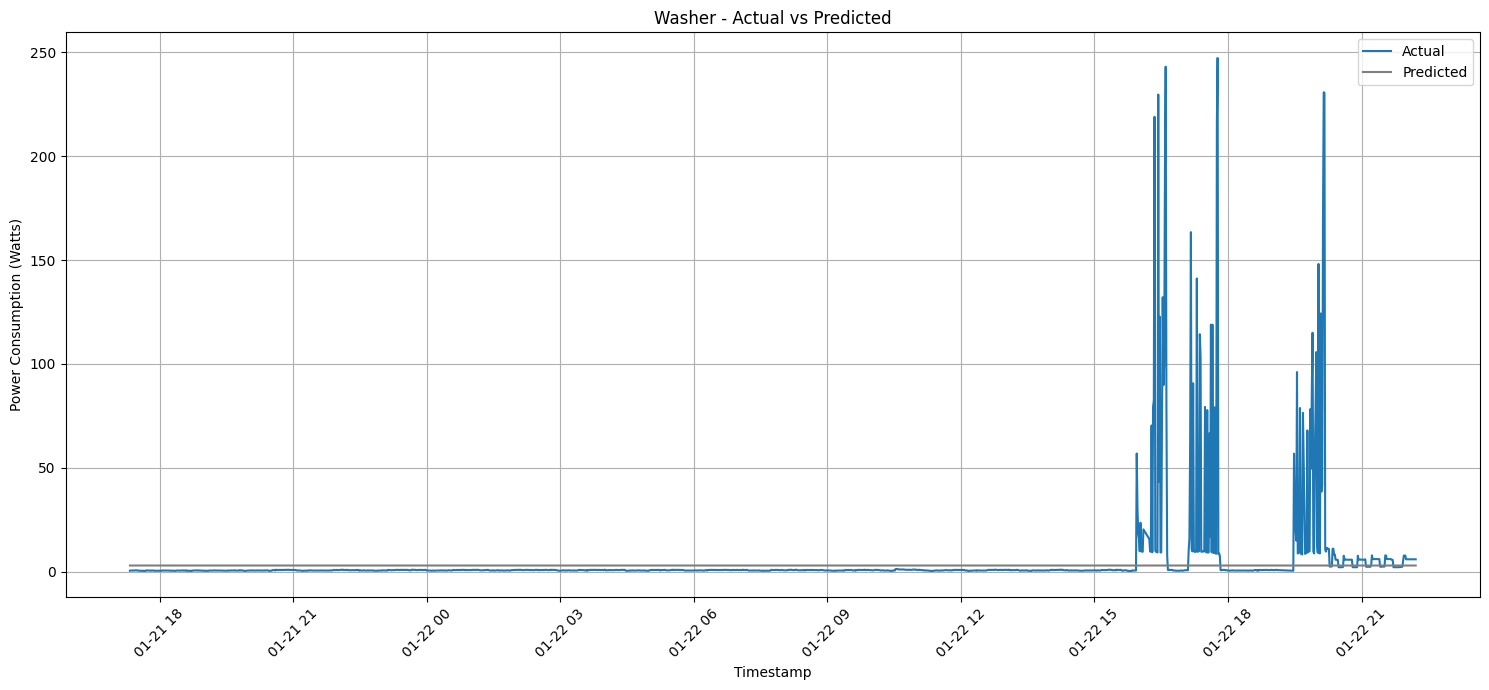

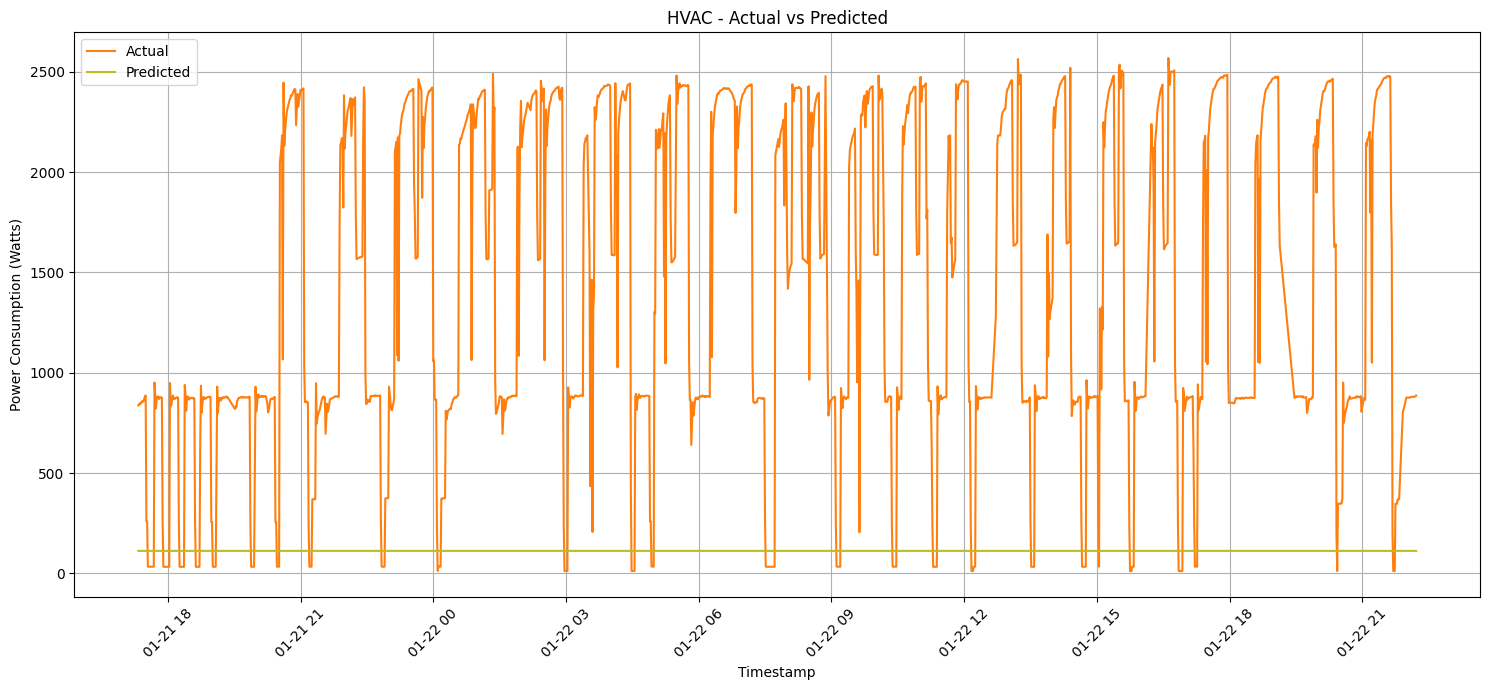

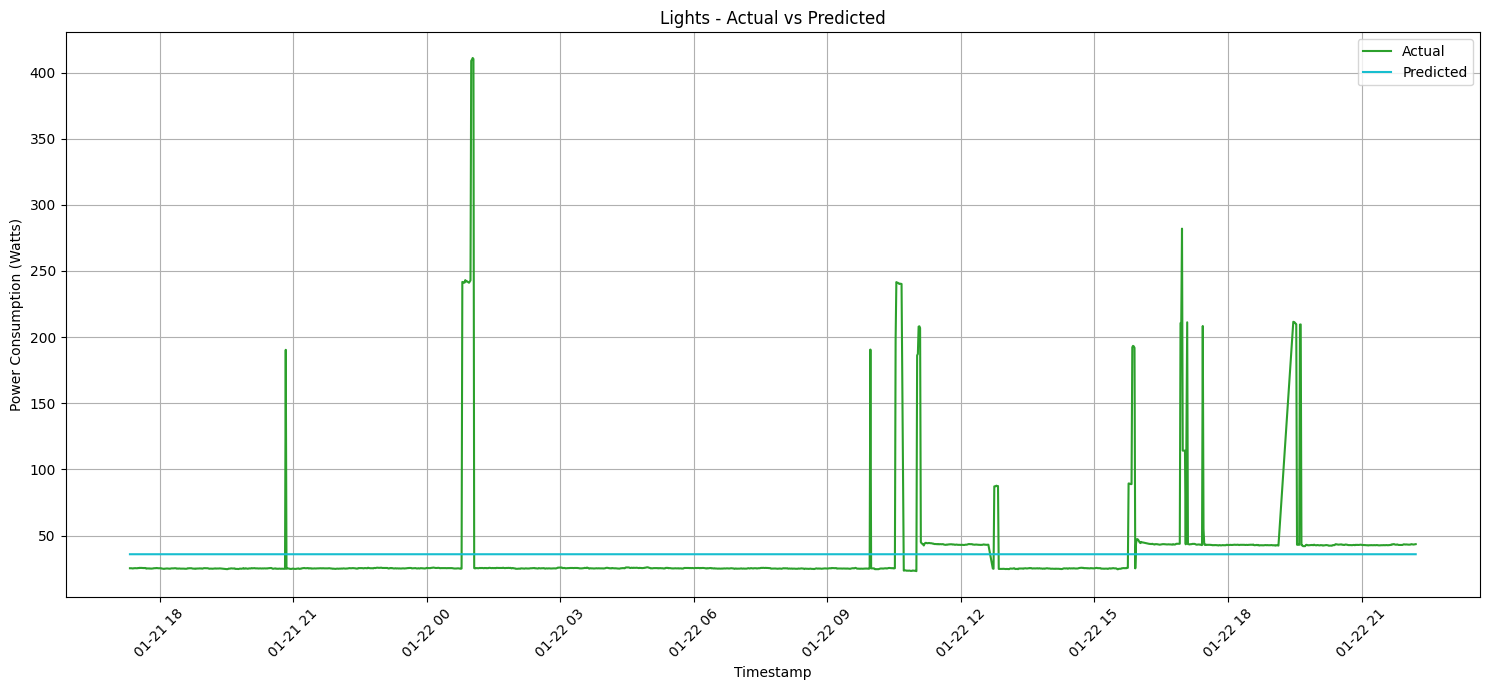

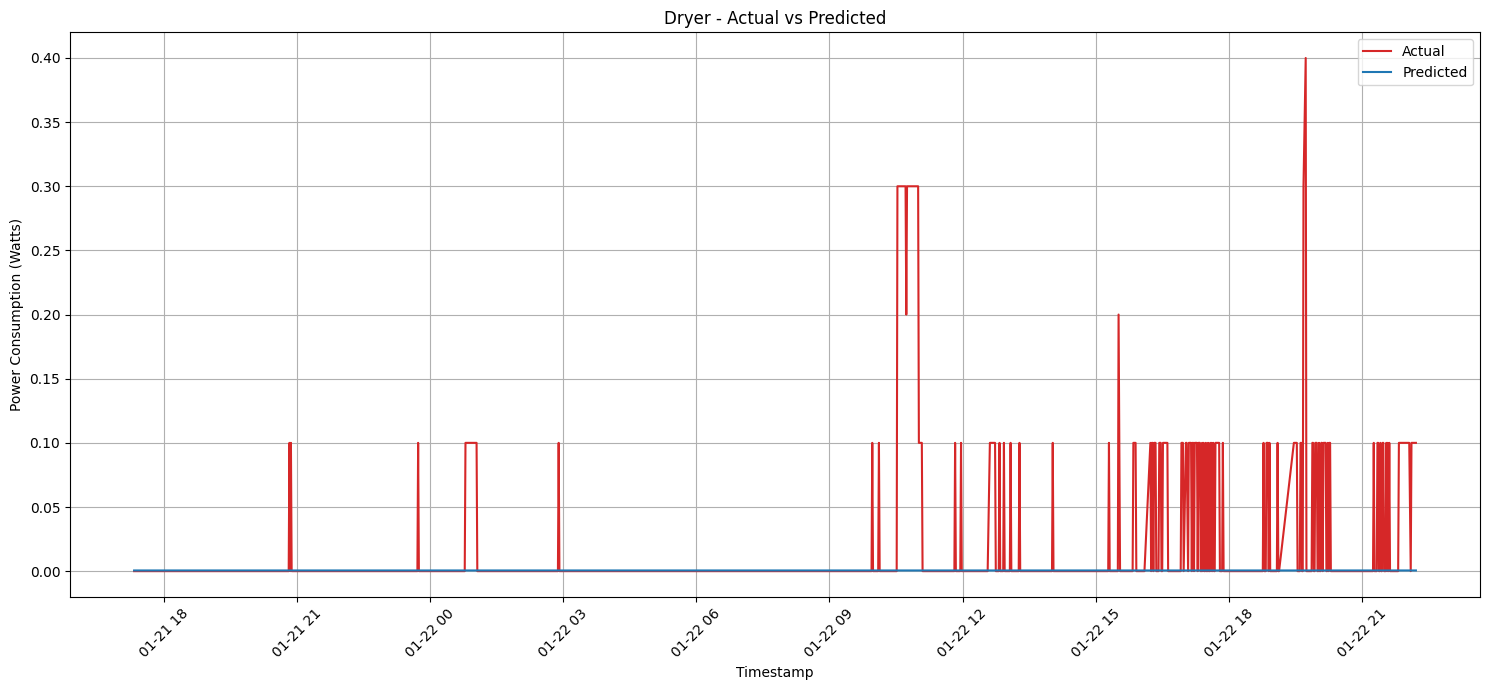

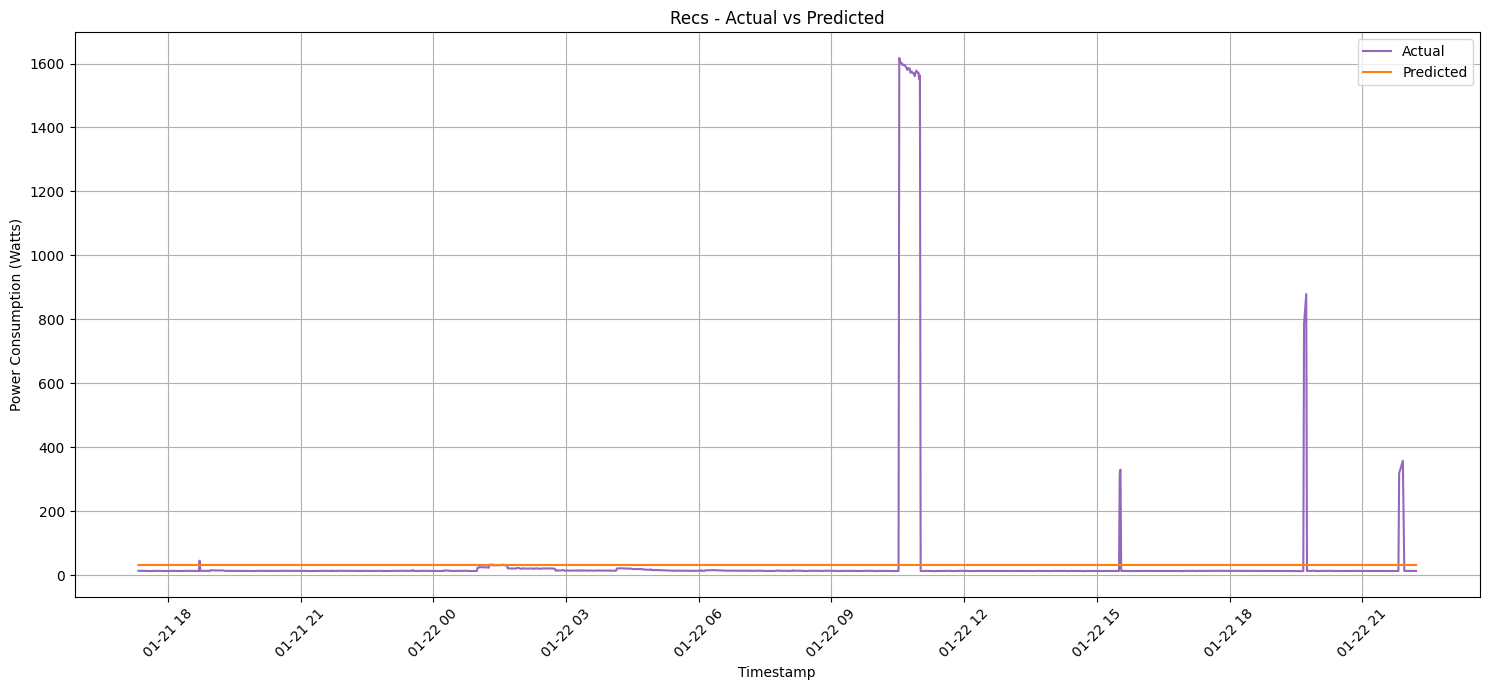

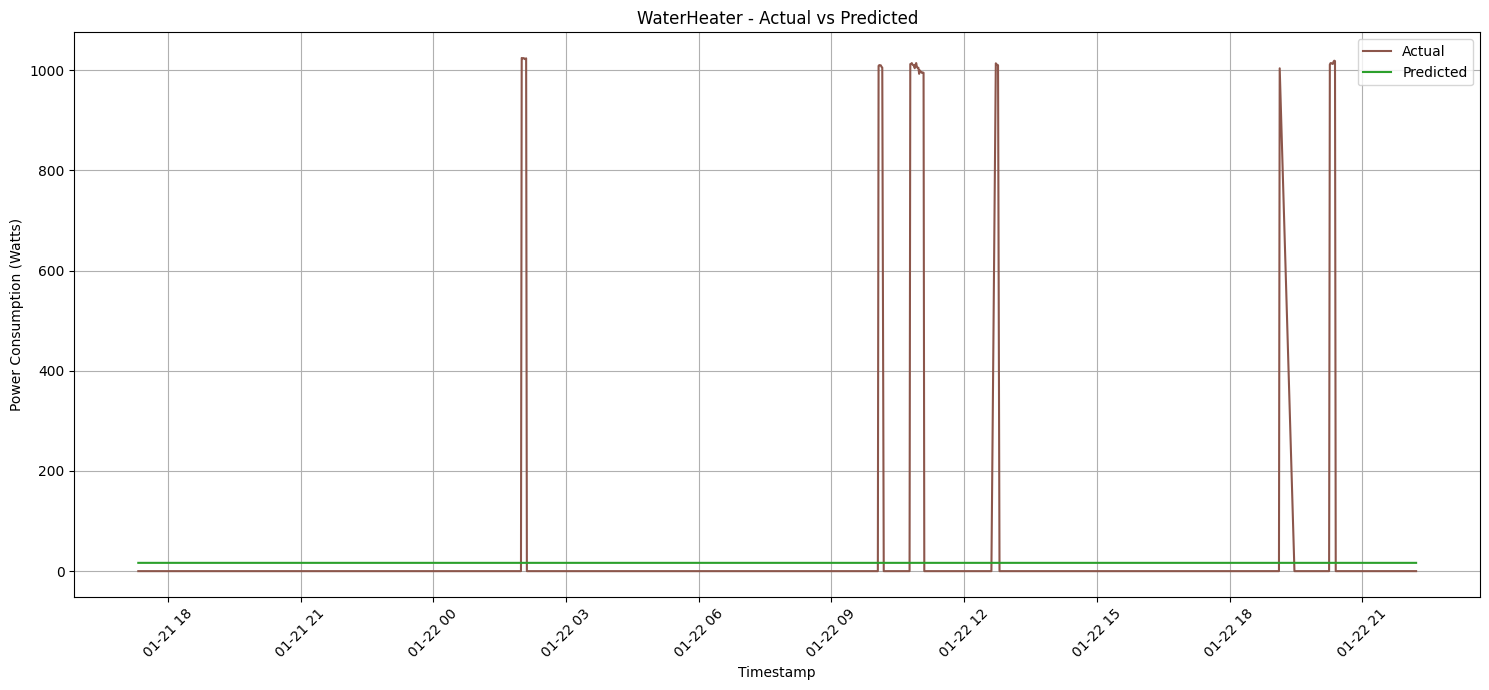

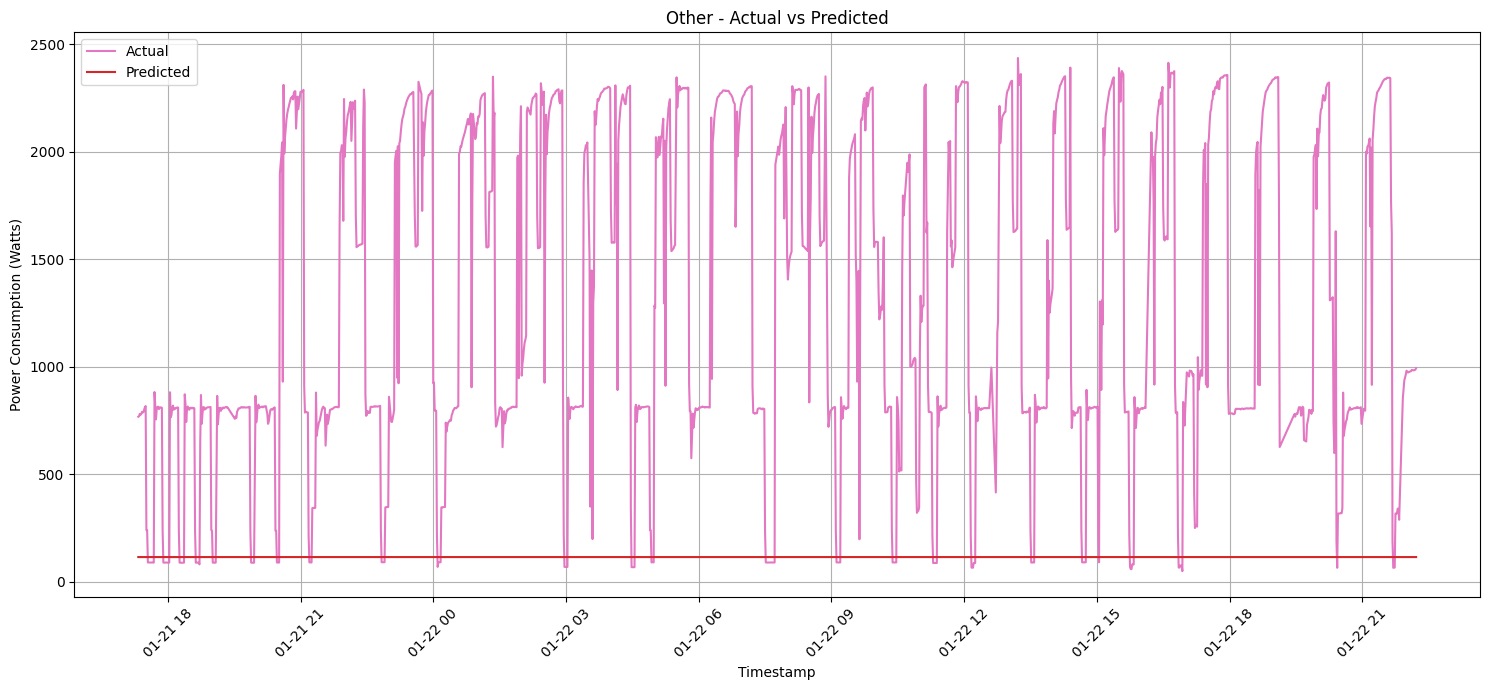

In [21]:
#X_test_reshaped = X_test.reshape(X_test.shape[0], TIME_STEPS, X_test.shape[2])

predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back in Watts instead of normalized
predicted_values = abs(predictions)
actual_values = abs(y_test)

print(predicted_values)

# Extract timestamps for test
test_timestamps = data['timestamp'].iloc[-len(X_test):]

appliance_names = ['Washer', 'HVAC', 'Lights', 'Dryer', 'Recs', 'WaterHeater', 'Other']

# Create an empty DataFrame to store the results
#results_df = pd.DataFrame(columns=['Appliance', 'Actual Total (Watts)', 'Predicted Total (Watts)', 'Percentage Error'])


for idx, appliance in enumerate(appliance_names):
    plt.figure(figsize=(15, 7))

    # Plot actual usage
    plt.plot(test_timestamps, actual_values[:, idx], label='Actual', color='C'+str(idx))

    # Plot predicted usage
    plt.plot(test_timestamps, predicted_values[:, idx], label='Predicted', color='C'+str(idx+7))

    plt.title(f"{appliance} - Actual vs Predicted")
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (Watts)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate actual and predicted total power in watts for the current appliance
    actual_total = actual_values[:, idx].sum()
    predicted_total = predicted_values[:, idx].sum()

    #This was using simple error percentage, switch to MAPE
    # Calculate the percentage error for the current appliance
#    percentage_error = abs(((actual_total - predicted_total) / actual_total) * 100)

    # Calculate the Mean Absolute Percentage Error (MAPE) for the current appliance
#    absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
#    mape = np.mean(absolute_percentage_error) * 100

    # some MAPE value are extremely high due to a 0 or near 0 value for the actual at a certain point

    # Calculate the Root Mean Square Error (RMSE) for the current appliance
#    rmse = np.sqrt(np.mean((actual_values[:, idx] - predicted_values[:, idx]) ** 2))

    # Calculate the Mean Absolute Error (MAE) for the current appliance
#    mae = np.mean(np.abs(actual_values[:, idx] - predicted_values[:, idx]))


    # Append the results to the DataFrame
 #   results_df = results_df.append({'Appliance': appliance,
 #                                   'Actual Total (Watts)': actual_total,
 #                                   'Predicted Total (Watts)': predicted_total,
 #                                   #'Percentage Error': percentage_error,
 #                                   #'MAPE': mape,
 #                                   #'RMSE': rmse,
 #                                   'MAE': mae},
 #                                  ignore_index=True)

# Display the results DataFrame
#print(results_df)